# Learning to trace geometrical paths for faster Ray Tracing

TODO

In [1]:
from collections.abc import Iterator
from typing import Optional

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jaxtyping import Array, Float, PRNGKeyArray
from tqdm.notebook import trange

from differt2d.geometry import Path, Point, Wall, path_length
from differt2d.models.cost20120 import Model
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Problem definition

The goal of our model is to generate all the paths, of a given order, between TX and RX in a 2D scene.

Here, the

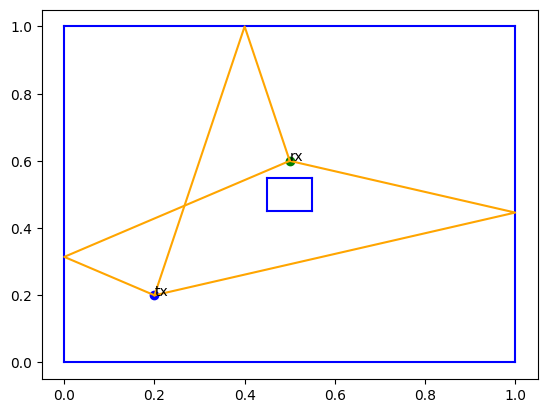

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(approx=False):
    path.plot(ax)

plt.show()

## Training data generation

In [3]:
key = jax.random.PRNGKey(12345)
key, key_example = jax.random.split(key, 2)


def random_scenes(
    key: PRNGKeyArray,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls = jax.random.split(key, 5)
        ratio = jax.random.uniform(key_ratio)
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(point=points[0, :])
        rx = Point(point=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        indices = jnp.arange(len(scene.objects), dtype=jnp.uint32)
        num_walls = jax.random.randint(
            key_num_walls, (), minval=0, maxval=len(scene.objects) + 1
        )
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        objects = [scene.objects[wall_index] for wall_index in wall_indices]

        points = jnp.vstack([points, *[obj.points for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    key: PRNGKeyArray, order: int = 1
) -> Iterator[
    tuple[Float[Array, "2+num_walls*2 2"], Float[Array, "num_paths {order}+2 2"]]
]:
    for scene, points in random_scenes(key):
        paths = [
            path.points
            for _, _, path, _ in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        if len(paths) > 0:
            y = jnp.stack(paths)
        else:
            y = jnp.zeros((0, order + 2, 2))

        yield points, y


scenes = random_scenes(key_example)

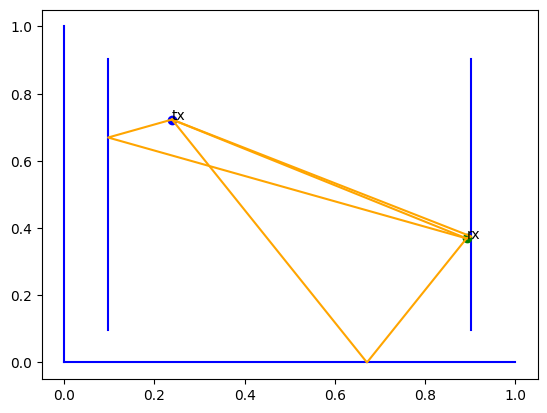

In [4]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(approx=False):
    path.plot(ax)

plt.show()

In [5]:
key_model, key_train, key_test = jax.random.split(key, 3)
train_samples = samples(key_train)
test_samples = samples(key_test)

## Loss function definition

In [6]:
def loss(
    model: Model,
    xy: Float[Array, "2+num_walls*2 2"],
    y_true: Float[Array, "num_paths order+2 2"],
    plot: bool = False,
    *,
    key: Optional[PRNGKeyArray] = None,
    inference: Optional[bool] = None,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    During training, the model returns a fixed number of paths, each having a "probability of being valid" attached.
    During inference, the model returns only the first X paths with probability "p >= model.threshold".

    The procedure is as follows:

    1 - the paths are ordered by ascending length;
    2 - if the number of generated paths does not match the ground truth,
        a penalty is computed and the paths are truncated to match the number of paths;
    3 - paths coordinates are compared element-wise and summed;
    4 - ...

    The loss is computed by comparing the generated path with the
    """
    y = model(xy, key=key, inference=inference)

    if isinstance(y, tuple):  # Training
        y_prob, y_pred = y
    else:  # Inference
        y_pred = y
        y_prob = jnp.ones((y_pred.shape[0],))

    if plot:
        order = model.order
        tx = Point(point=xy[0, :])
        rx = Point(point=xy[1, :])
        walls = xy[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(points=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)

        for _, _, path, _ in scene.all_valid_paths(
            min_order=order, max_order=order, approx=False
        ):
            path.plot(ax, color="orange")

        for p, path in zip(y_prob, y_pred):
            print(float(p))
            Path(points=path).plot(ax, alpha=1, color="red")

    # 1 - sort-by length (ascending)

    los_distance = path_length(xy[:2, ...])  # Distance between TX and RX

    paths_length_true = jax.vmap(path_length)(y_true)
    sort_indices_true = jnp.argsort(paths_length_true)
    paths_length_true = paths_length_true[sort_indices_true] / los_distance
    y_true = y_true[sort_indices_true, ...]

    paths_length_pred = jax.vmap(path_length)(y_pred)
    sort_indices_pred = jnp.argsort(paths_length_pred)
    paths_length_pred = paths_length_pred[sort_indices_pred] / los_distance
    y_pred = y_pred[sort_indices_pred, ...]
    y_prob = y_prob[sort_indices_pred]

    # 2 - check the number of paths

    num_paths_pred = y_pred.shape[0]
    num_paths_true = y_true.shape[0]

    if num_paths_pred < num_paths_true:  # Too few paths
        # Penalty is inversely-prop. to the length of paths we discarded.
        penalty = jnp.sum(1 / paths_length_true[num_paths_pred:])
        y_true = y_true[:num_paths_pred, ...]
        paths_length_true = paths_length_true[:num_paths_pred, ...]
    elif num_paths_pred > num_paths_true:  # Too many paths
        # Same as above, but weighted with respective probability
        penalty = jnp.sum(
            y_prob[num_paths_true:, ...] / paths_length_pred[num_paths_true:, ...]
        )
        y_pred = y_pred[:num_paths_true, ...]
        y_prob = y_prob[:num_paths_true, ...]
    else:
        penalty = 0.0

    # the longer the path, the less important

    weights = (1.5 - y_prob) / paths_length_true

    differences = (y_true[:, 1:-1, :] - y_pred[:, 1:-1, :]).sum(axis=(1, 2)) ** 2

    result = (weights * differences).sum() + penalty

    return result

In [7]:
training_model = Model(key=key_model)
optim = optax.adam(learning_rate=1e-3)

0.37048304080963135
0.37048304080963135
0.37048304080963135
0.37048304080963135
0.37048304080963135


Array(3.0031996, dtype=float32)

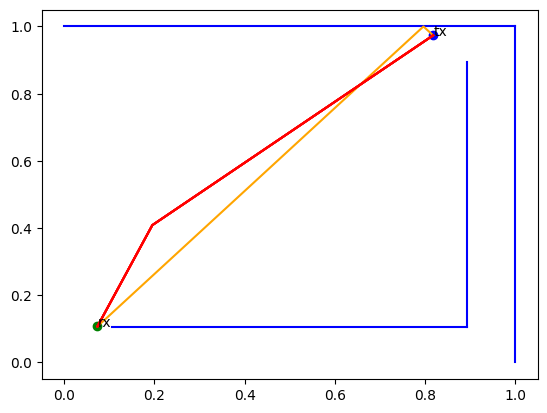

In [8]:
loss(training_model, *next(train_samples), plot=True)  # Untrained model

In [15]:
def train(
    model: Model,
    train_samples: Iterator,
    test_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 10,
    print_every: int = 1_000,
    num_test_samples: int = 100,
    *,
    key: Optional[PRNGKeyArray] = None,
    inference: Optional[bool] = None,
):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: Model,
        opt_state: optax.OptState,
        xy: Float[Array, "2+num_walls*2 2"],
        y_true: Float[Array, "num_paths order+2 2"],
        *,
        key: Optional[PRNGKeyArray] = None,
        inference: Optional[bool] = None,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xy, y_true, key=key, inference=inference
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    with trange(steps, desc="", unit=" steps", leave=False) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            if key is not None:
                key, key_step = jax.split(key, 2)
            else:
                key_step = None

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            if (step % print_every) == 0 or (step == steps - 1):
                test_loss = 0
                for _, (x_test, y_test) in zip(
                    range(num_test_samples),
                    test_samples,
                ):
                    test_loss += loss(model, x_test, y_test)
                test_loss /= num_test_samples

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, test_loss = {float(test_loss):.1f}"
                )

    return model

In [16]:
training_model = train(training_model, train_samples, test_samples, optim)
# inference_model = eqx.nn.inference_mode(training_model)  # TODO: fixme
inference_model = training_model

  0%|          | 0/10 [00:00<?, ? steps/s]

0.3497372269630432
0.3494351804256439
0.3493238389492035
0.34928449988365173
0.34927111864089966


Array(0.9828809, dtype=float32)

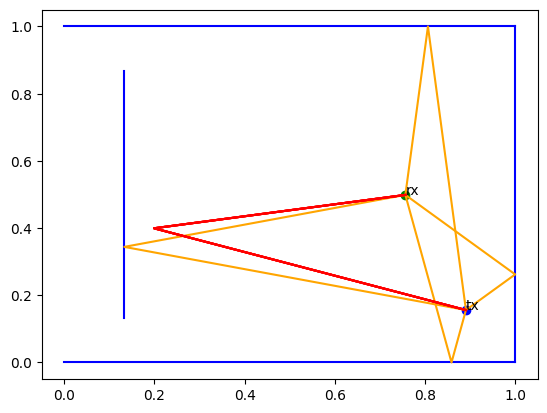

In [17]:
loss(inference_model, *next(test_samples), plot=True)